# analyze binclf speed test

Test which variation of FPR computation is faster.

# setup

In [1]:
from __future__ import annotations

In [2]:
# make a cell print all the outputs instead of just the last one
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# adjust the number of significant digits 
import pandas as pd
pd.set_option('display.precision', 5)

# load

In [3]:
from pathlib import Path
# LOAD_DIR = Path("./.cache/binclf-speed-test")
LOAD_DIR = Path("./.cache/binclf-speed-test-samet")
assert LOAD_DIR.exists()

from pathlib import Path
csv_fpaths = sorted(LOAD_DIR.glob('*.csv'))
print(f"{len(csv_fpaths)} csv files found")

import pandas as pd
df = pd.concat([pd.read_csv(fpath) for fpath in csv_fpaths], ignore_index=True, axis=0, sort=False)
df["imgs_persec"] = df["num_images"] / df["seconds"]

df.head()
df.shape

20 csv files found


,resolution,num_images,num_thresholds,seed,algorithm,device,hostname,num_cpus,seconds,imgs_persec
0,256,100,10000,0,numpy_itertools,cpu,sakcay-pc,36,2.35870,42.39626
1,256,100,10000,0,numpy_itertools,cpu,sakcay-pc,36,2.35052,42.54382
2,256,100,10000,0,numpy_itertools,cpu,sakcay-pc,36,2.35098,42.53550
3,256,100,10000,0,numpy_itertools,cpu,sakcay-pc,36,2.35280,42.50258
4,256,100,10000,0,numpy_itertools,cpu,sakcay-pc,36,2.34914,42.56874


(100, 10)

In [4]:
EXPERIMENT_COLS = ["resolution", "num_images", "num_thresholds", "seed", "algorithm", "device"]
MACHINE_COLS = ["hostname", "num_cpus"]
MEASUREMENT_COLS = ["seconds", "imgs_persec"]

In [5]:
unique_experiments = df[EXPERIMENT_COLS].drop_duplicates()
unique_experiments.shape

(20, 6)

In [6]:
df.sort_values(EXPERIMENT_COLS + MEASUREMENT_COLS[:1], inplace=True)

# experiment 1: all algorithms

On each plot:
    - x-axis: `num_thrsholds`
    - y-axis: `imgs_persec`
    - each line is a different (`algorithm`, `device`)
    - `device == 'cuda'` is in dashed line

Subplots:
    - column: `resolution`
    - row: `num_images`

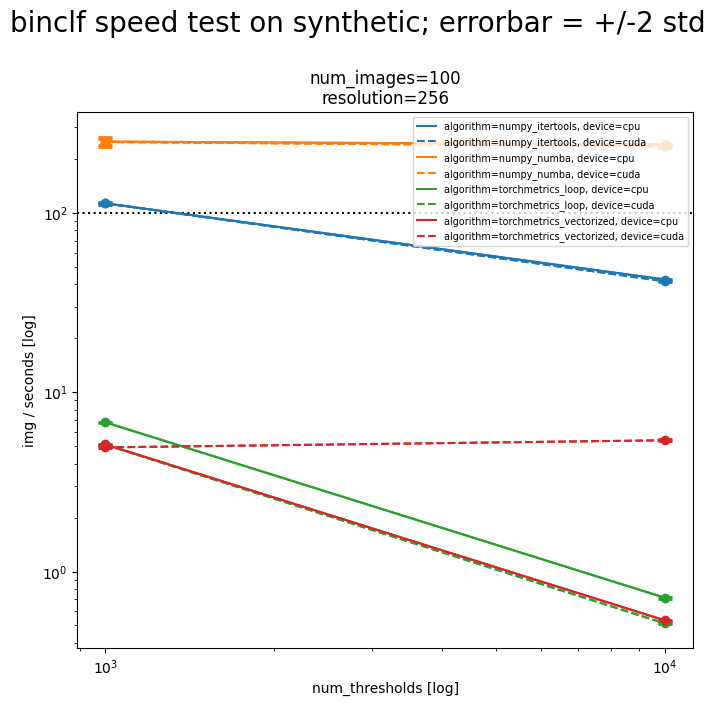

In [7]:
import numpy as np
from matplotlib import pyplot as plt

PLOTGRID_ROW_COLS = ["num_images"]
PLOTGRID_COL_COLS = ["resolution"]
LINE_COLS = ["algorithm", "device"]

dfplot = df.query("num_images not in (10,) and algorithm not in ('numpy_numba_parallel')")

# `pg` stands for `plotgrid`
pg_row_dfidxs = dfplot.groupby(PLOTGRID_ROW_COLS).size().index.tolist()
pg_col_dfidxs = dfplot.groupby(PLOTGRID_COL_COLS).size().index.tolist()

fig, axes = plt.subplots(nr := len(pg_row_dfidxs), nc := len(pg_col_dfidxs), figsize=(nc * (sz := 7), nr * sz))
axes = (axes if nr*nc > 1 else np.array(axes) ).reshape(nr, nc) 

# `gidx` stands for `group index` , `gdf` stands for `group dataframe`
for pgrow_gidx, pgrow_gdf in dfplot.groupby(PLOTGRID_ROW_COLS):
    for pgcol_gidx, pgcol_gdf in pgrow_gdf.groupby(PLOTGRID_COL_COLS):
        
        if len(pgcol_gdf) == 0:
            continue
        
        # convert dataframe index (tuple[any]) into int index of the plotgrid rows and columns 
        # it has to be converted like this because some `pgrow_df` may not have all the column groups
        # `ridx`/`cidx` stands for `row-index`/`col-index`
        pg_ridx = pg_row_dfidxs.index(pgrow_gidx[0] if len(pgrow_gidx) == 1 else pgrow_gidx)
        pg_cidx = pg_col_dfidxs.index(pgcol_gidx[0] if len(pgcol_gidx) == 1 else pgcol_gidx)
        ax = axes[pg_ridx, pg_cidx]
        
        # `rname`/`cname` stands for `row-name`/`col-name`
        pg_rname = ", ".join(map("=".join, zip(PLOTGRID_ROW_COLS, map(str, pgrow_gidx))))
        pg_cname = ", ".join(map("=".join, zip(PLOTGRID_COL_COLS, map(str, pgcol_gidx))))
        _ = ax.set_title(f"{pg_rname}\n{pg_cname}")
        
        # CUSTOM
        pgcol_gdf.sort_values(LINE_COLS, inplace=True)  # important for the color/dashed logic
        
        for line_gidx, line_gdf in pgcol_gdf.groupby(LINE_COLS):
            
            # `lname` stands for `line-name`
            pg_lname = ", ".join(map("=".join, zip(LINE_COLS, map(str, line_gidx))))

            # --- CUSTOM ---
            data = line_gdf.groupby("num_thresholds").describe()["imgs_persec"][["mean", "std", "count"]].reset_index()
            xs = data["num_thresholds"]
            ys = data["mean"]
            yerr = data["std"] * 2
            algorithm, device = line_gidx

            if device == "cpu": 
                line_handle = ax.plot(xs, ys, label=pg_lname, linestyle="-")[0]
            else:
                # plot here is from the previous iteration
                line_handle = ax.plot(xs, ys, label=pg_lname, linestyle="--", color=line_handle.get_color())[0]
            
            if not np.isnan(yerr).any():
                _ = ax.errorbar(
                    xs, ys, yerr=yerr, 
                    fmt='o', capsize=5, capthick=2, 
                    ecolor=line_handle.get_color(), color=line_handle.get_color(), linestyle=line_handle.get_linestyle()
                )
        
        _ = ax.axhline(100, color='k', linestyle=":")    
        
        _ = ax.set_xscale("log")
        _ = ax.set_yscale("log")
        _ = ax.set_xlabel("num_thresholds [log]")
        _ = ax.set_ylabel("img / seconds [log]")
        _ = ax.legend(loc='upper right', fontsize='x-small')
        

lims = np.array([[ax.get_xlim(), ax.get_ylim()] for ax in axes.flatten()]).reshape(axes.shape + (2, 2))
pgrows_lims = np.stack([lims[..., 0].min(axis=1), lims[..., 1].max(axis=1)], axis=-1)
pgcols_lims = np.stack([lims[..., 0].min(axis=0), lims[..., 1].max(axis=0)], axis=-1)

# grid-row: same y-axis limits
for ax, (ridx, cidx) in zip(axes.flatten(), np.ndindex(axes.shape)): _ = ax.set_ylim(pgrows_lims[ridx][1])
# grid-col: same x-axis limits
for ax, (ridx, cidx) in zip(axes.flatten(), np.ndindex(axes.shape)): _ = ax.set_xlim(pgcols_lims[cidx][0])

# turn off axes for subplots that are empty    
for ax in [ax for ax in axes.flatten() if not ax.get_title()]: _ = ax.set_visible(False)

_ = fig.suptitle("binclf speed test on synthetic; errorbar = +/-2 std", fontsize=20, y=1.002)
_ = fig.tight_layout(h_pad=0, w_pad=0)
_ = fig.subplots_adjust(hspace=0.3, wspace=0.2)

# experiment 1: numba vs numba parallel

On each plot:
    - x-axis: ``
    - y-axis: ``

Subplots:
    - column: ``
    - row: ``

In [8]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

PLOTGRID_ROW_COLS = ["device"]
PLOTGRID_COL_COLS = ["algorithm"]
LINE_COLS = []
# "device"

dfplot = df.query("num_images in (200,) and algorithm in ('numpy_numba', 'numpy_numba_parallel', 'numpy_itertools')")

# `pg` stands for `plotgrid`
pg_row_dfidxs = dfplot.groupby(PLOTGRID_ROW_COLS).size().index.tolist() if len(PLOTGRID_ROW_COLS) > 0 else [None]
pg_col_dfidxs = dfplot.groupby(PLOTGRID_COL_COLS).size().index.tolist() if len(PLOTGRID_COL_COLS) > 0 else [None]

fig, axes = plt.subplots(nr := len(pg_row_dfidxs), nc := len(pg_col_dfidxs) + 1, figsize=(nc * (sz := 5), nr * sz))
axes = (axes if nr*nc > 1 else np.array(axes) ).reshape(nr, nc) 

# `gidx` stands for `group index` , `gdf` stands for `group dataframe`
for pgrow_gidx, pgrow_gdf in dfplot.groupby(PLOTGRID_ROW_COLS) if len(PLOTGRID_ROW_COLS) > 0 else [((None,), dfplot)]:
    for pgcol_gidx, pgcol_gdf in pgrow_gdf.groupby(PLOTGRID_COL_COLS) if len(PLOTGRID_COL_COLS) > 0 else [((None,), pgrow_gdf)]:
        if len(pgcol_gdf) == 0: continue
        
        # convert dataframe index (tuple[any]) into int index of the plotgrid rows and columns 
        # it has to be converted like this because some `pgrow_df` may not have all the column groups
        # `ridx`/`cidx` stands for `row-index`/`col-index`
        pg_ridx = pg_row_dfidxs.index(pgrow_gidx[0] if len(pgrow_gidx) == 1 else pgrow_gidx)  
        pg_cidx = pg_col_dfidxs.index(pgcol_gidx[0] if len(pgcol_gidx) == 1 else pgcol_gidx)  
        ax = axes[pg_ridx, pg_cidx]
        
        # `rname`/`cname` stands for `row-name`/`col-name`
        pg_rname = ", ".join(map("=".join, zip(PLOTGRID_ROW_COLS, map(str, pgrow_gidx)))) if pgrow_gidx[0] is not None else ""
        pg_cname = ", ".join(map("=".join, zip(PLOTGRID_COL_COLS, map(str, pgcol_gidx)))) if pgcol_gidx[0] is not None else ""
        _ = ax.set_title(f"{pg_rname}\n{pg_cname}".strip())
        
        for line_gidx, line_gdf in pgcol_gdf.groupby(LINE_COLS) if len(LINE_COLS) > 0 else [((None,), pgcol_gdf)]:
            if len(line_gdf) == 0: continue
            
            # `lname` stands for `line-name`
            pg_lname = ", ".join(map("=".join, zip(LINE_COLS, map(str, line_gidx)))) if line_gidx is not None else ""

            # ------------------------------------------------------------
            
            data = line_gdf.groupby(["resolution", "num_thresholds"]).describe()["imgs_persec"][["mean", "std"]].reset_index()
            xs = data["num_thresholds"]
            ys = data["resolution"]
            zs = np.log10(data["mean"])
            handle = ax.scatter(
                x=xs, y=ys, c=zs,
                marker="o", vmin=0, vmax=2, s=1000, cmap="bwr",
                label="log10(images / second)",
            )
            for x, y, z in zip(xs, ys, zs): _ = ax.annotate(f"{10**z:.0f}", (x, y))
                            
        _ = ax.set_aspect("equal")
        _ = ax.set_xscale("log")
        _ = ax.set_yscale("log", base=2)
        _ = ax.yaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
        _ = ax.set_xlabel("num_thresholds")
        _ = ax.set_ylabel("resolution")

    _ = fig.colorbar(handle, ax=axes[pg_ridx, -1], label="log10( images / second )", orientation="vertical", location="left")

# ------------------------------------------------------------
lims = np.array([[ax.get_xlim(), ax.get_ylim()] for ax in axes.flatten()]).reshape(axes.shape + (2, 2))
pgrows_lims = np.stack([lims[..., 0].min(axis=1), lims[..., 1].max(axis=1)], axis=-1)
pgcols_lims = np.stack([lims[..., 0].min(axis=0), lims[..., 1].max(axis=0)], axis=-1)

# grid-row: same y-axis limits
# for ax, (ridx, cidx) in zip(axes.flatten(), np.ndindex(axes.shape)): _ = ax.set_ylim(pgrows_lims[ridx][1])
# grid-col: same x-axis limits
# for ax, (ridx, cidx) in zip(axes.flatten(), np.ndindex(axes.shape)): _ = ax.set_xlim(pgcols_lims[cidx][0])

# turn off axes for subplots that are empty    
for ax in [ax for ax in axes.flatten() if not ax.get_title()]: _ = ax.set_visible(False)

_ = fig.suptitle("algorithm characterization: images / sec (average on datasets of 200 images)", fontsize=20, y=1.002)
_ = fig.tight_layout(h_pad=0, w_pad=0)
_ = fig.subplots_adjust(hspace=0.4, wspace=0.2)

ValueError: Number of rows must be a positive integer, not 0

<Figure size 500x0 with 0 Axes>